**Neural Network for Tabla Taal Classification**
As a student of tabla, I thought this would be an interesting problem to tackle. I used Keras libraries and librosa to extract features from the raw .wav files. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import librosa
from librosa import feature
import librosa.display

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import keras
from keras.layers import *
from keras import metrics
from keras.utils import to_categorical

import sklearn
from sklearn.model_selection import train_test_split

import csv

import IPython.display as ipd

firstfilepath = '../input/tabla-taala-dataset/tablaDataset/addhatrital/addhatrital01.wav'
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
x, sr = librosa.load(firstfilepath)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


This is a quick feature analysis of the very first file in our dataset, addhatrital01.wav. This is the raw .wav file.

In [3]:
ipd.Audio(firstfilepath)

This is a wave plot of the first example file.

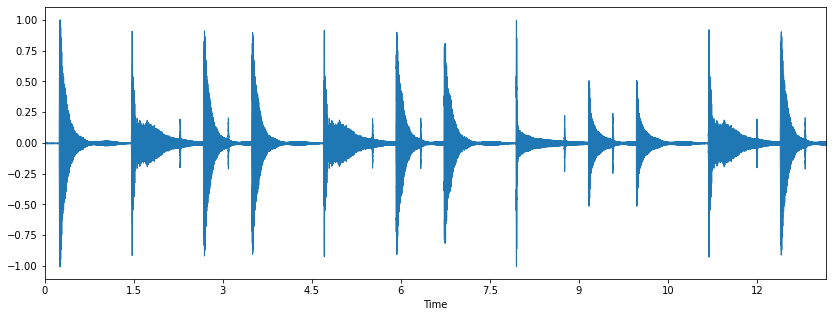

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

A chroma vector a a 12-element feature vector of the relative energy of each pitch class in the signal. The following plot is a chromagram of the first example file.

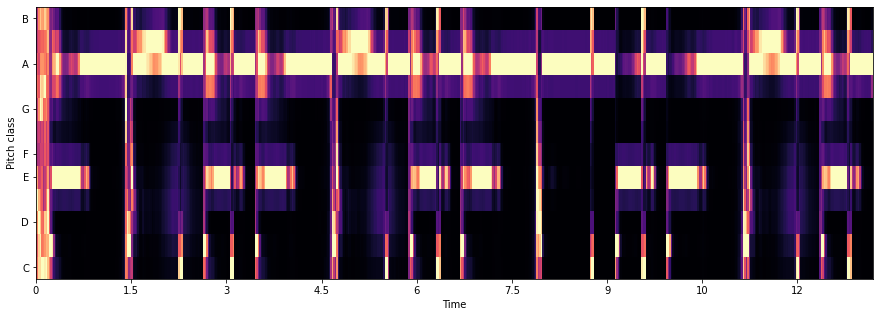

In [5]:
chromagram = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')

The RMSE (root mean squared energy) of the signal, defined as

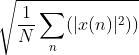

where x(n) is a time signal.

In [6]:
example_rmse = librosa.feature.rms(x)
print(example_rmse.shape)
print(np.mean(example_rmse))

(1, 568)
0.051427454


The center of mass of the signal, e.g. the weighted mean of frequencies in the signal.

1848.4915588957338


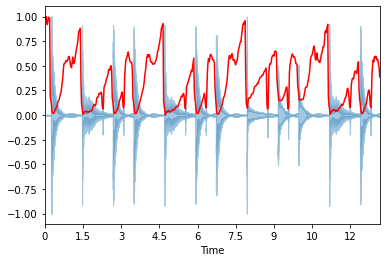

In [7]:
example_spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
example_spectral_centroids.shape
frames = range(len(example_spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_centroids), color='r')
print(np.mean(example_spectral_centroids))

Order p spectral bandwidth is defined as 

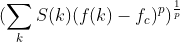

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at frequency bin k, and fc is the spectral centroid. 

2428.738220336647


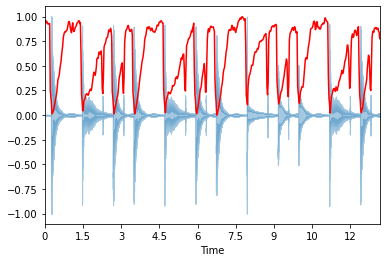

In [8]:
example_spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)[0]
example_spectral_bandwidth.shape
frames = range(len(example_spectral_bandwidth))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='r')
print(np.mean(example_spectral_bandwidth))

The spectral rolloff is a frequency below which a certain percentage of spectral energy lies.

4155.131036462918


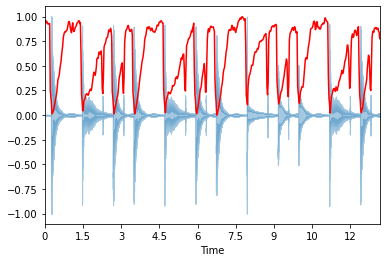

In [9]:
example_spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
example_spectral_rolloff.shape
frames = range(len(example_spectral_rolloff))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='r')
print(np.mean(example_spectral_rolloff))

The zero crossing rate is the rate at which the signal changes sign (crosses y = 0). 

7


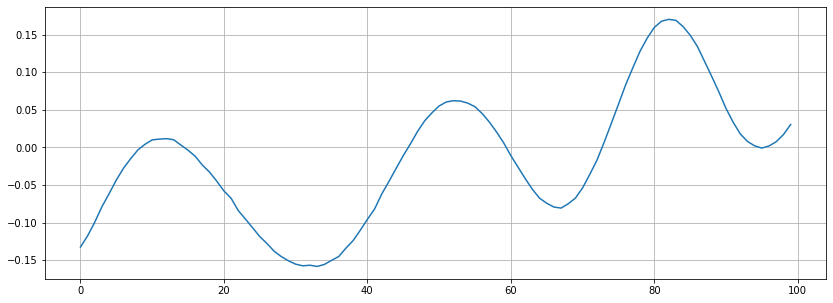

In [10]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

The Mel-Frequency Cepstral Coefficients (MFCCs) are a set of features which describe the shape of a spectral envelope.

(20, 568)
-12.632415


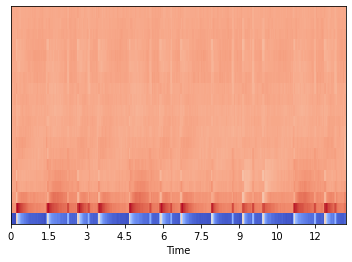

In [11]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
print(np.mean(mfccs))

Features: Chroma features, RMSE, Spectral Centroid, Spectral Bandwidth, Spectral Rolloff, Zero Crossing Rate, MFCCs

In [12]:
header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating the dataframe.

In [13]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
taals = 'addhatrital bhajani dadra deepchandi ektal jhaptal rupak trital'.split()
for t in taals:
    for filename in os.listdir(f'../input/tabla-taala-dataset/tablaDataset/{t}'):
        taalfile = f'../input/tabla-taala-dataset/tablaDataset/{t}/{filename}'
        y, sr = librosa.load(taalfile, mono=True, duration=30)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} '    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {t}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [14]:
data = pd.read_csv('dataset.csv')
print(data)

     chroma_stft       rms  spectral_centroid  spectral_bandwidth  \
0       0.290550  0.103630        1103.798931         1700.043962   
1       0.326335  0.045529        2365.084142         2622.179078   
2       0.296053  0.050485        1974.050446         2400.680944   
3       0.254276  0.058988        1680.376629         2238.254300   
4       0.280416  0.049690        1886.927349         2344.335828   
..           ...       ...                ...                 ...   
556     0.298480  0.216349         986.257149         1439.194361   
557     0.279002  0.164812        1099.327206         1570.283999   
558     0.249985  0.168430         971.172079         1520.078150   
559     0.279491  0.145864        1251.011153         1684.686901   
560     0.288573  0.152695        1105.997349         1581.021535   

         rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
0    1783.650529            0.049771 -337.091309  135.239822  35.175713   
1    5101.686262     

Mapping the taal names to integers from 0 to 7.

In [15]:
d = dict(zip(taals, range(0,8)))
d

{'addhatrital': 0,
 'bhajani': 1,
 'dadra': 2,
 'deepchandi': 3,
 'ektal': 4,
 'jhaptal': 5,
 'rupak': 6,
 'trital': 7}

In [16]:
data['label'] = data['label'].map(d)
print(data)

     chroma_stft       rms  spectral_centroid  spectral_bandwidth  \
0       0.290550  0.103630        1103.798931         1700.043962   
1       0.326335  0.045529        2365.084142         2622.179078   
2       0.296053  0.050485        1974.050446         2400.680944   
3       0.254276  0.058988        1680.376629         2238.254300   
4       0.280416  0.049690        1886.927349         2344.335828   
..           ...       ...                ...                 ...   
556     0.298480  0.216349         986.257149         1439.194361   
557     0.279002  0.164812        1099.327206         1570.283999   
558     0.249985  0.168430         971.172079         1520.078150   
559     0.279491  0.145864        1251.011153         1684.686901   
560     0.288573  0.152695        1105.997349         1581.021535   

         rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
0    1783.650529            0.049771 -337.091309  135.239822  35.175713   
1    5101.686262     

The following code performs an 80/20 train/test split on the data after splitting it into train and test data. The order of the data is also randomized. The label data is also changed to one-hot encoding.

In [17]:
y = data['label']
X = data.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)
print(y_test)

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1.

Creating a Keras Sequential model. The last layer has a softmax activation function.

In [18]:

model = keras.models.Sequential()
model.add(Dense(128, input_dim = 26, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))


Compiling the model with the following loss function, optimizer, and metric.

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training the model.

In [20]:
model.fit(X_train, y_train, batch_size = 10, epochs = 300, verbose = 1)

Epoch 1/300
45/45 [==============================] - 0s 2ms/step - loss: 49.1007 - accuracy: 0.1138
Epoch 2/300
45/45 [==============================] - 0s 2ms/step - loss: 21.1015 - accuracy: 0.1652
Epoch 3/300
45/45 [==============================] - 0s 2ms/step - loss: 11.1790 - accuracy: 0.1808
Epoch 4/300
45/45 [==============================] - 0s 2ms/step - loss: 15.7443 - accuracy: 0.2321
Epoch 5/300
45/45 [==============================] - 0s 2ms/step - loss: 11.1503 - accuracy: 0.2522
Epoch 6/300
45/45 [==============================] - 0s 2ms/step - loss: 7.1428 - accuracy: 0.2344
Epoch 7/300
45/45 [==============================] - 0s 2ms/step - loss: 8.1070 - accuracy: 0.2522
Epoch 8/300
45/45 [==============================] - 0s 2ms/step - loss: 6.0026 - accuracy: 0.2679
Epoch 9/300
45/45 [==============================] - 0s 2ms/step - loss: 5.1751 - accuracy: 0.3103
Epoch 10/300
45/45 [==============================] - 0s 2ms/step - loss: 7.4760 - accuracy: 0.2656
Epoc

Accuracy:

In [21]:
loss = model.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9912


Summary of the model.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3456      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 37,512
Trainable params: 37,512
Non-trainable params: 0
_________________________________________________________________
